In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UMI.BR'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,4031,-3395,636,73,124,847,1095,2101,0,...,0,0,269,1474,57,1997,195,-70,219.28,2014-07-21
1,2014-12-31,4141,-3496,645,91,90,827,1183,2141,0,...,0,0,366,1607,23,2147,201,-124,214.66,2015-02-14
2,2015-06-30,5074,-4337,737,86,50,860,1108,2056,0,...,0,0,386,1573,38,2362,51,-94,218.20,2015-07-21
3,2015-12-31,4682,-3980,702,75,75,830,1054,1996,0,...,0,0,339,1526,71,2298,250,-132,217.70,2016-02-14
4,2016-06-30,4848,-4126,722,105,97,827,1029,1985,0,...,0,0,379,1488,25,2360,168,-87,218.20,2016-07-21


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2021-12-31,2022-02-14,242.16,11376,-10735,641,222,1194,1832,2869,...,340,9045,0,0,431,3480,1724,5932,486,-237
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,343,10259,0,0,793,4553,1640,6849,422,-201
17,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,343,9942,0,0,717,4134,1626,6426,212,-290
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,382,9860,0,0,729,3613,2007,6265,274,-349
19,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,381,9966,0,0,729,3596,2019,6305,768,-536


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-14,242.16,11376,-10735,641,222,1194,1832,2869,...,9045,0,0,431,3480,1724,5932,486,-237,0.874514
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
17,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
19,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-14,242.16,11376,-10735,641,222,1194,1832,2869,...,9045,0,0,431,3480,1724,5932,486,-237,0.874514
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
17,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
19,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-21,14.198153,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.454222,0.545778,0.0,0.0,0.0,0.0,0.157777,0.01811,0.0,0.0
1,2014-07-28,14.326042,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.454222,0.545778,0.0,0.0,0.0,0.0,0.157777,0.01811,0.0,0.0
2,2014-08-04,14.238117,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.454222,0.545778,0.0,0.0,0.0,0.0,0.157777,0.01811,0.0,0.0
3,2014-08-11,14.545861,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.454222,0.545778,0.0,0.0,0.0,0.0,0.157777,0.01811,0.0,0.0
4,2014-08-18,14.723713,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.454222,0.545778,0.0,0.0,0.0,0.0,0.157777,0.01811,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-21,14.198153,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.0,0.157777,0.01811,0.0,0.0,inf,1.873268,0.386178,0.618503,inf
1,2014-07-28,14.326042,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.0,0.157777,0.01811,0.0,0.0,inf,1.890141,0.389657,0.621981,inf
2,2014-08-04,14.238117,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.0,0.157777,0.01811,0.0,0.0,inf,1.878541,0.387265,0.619590,inf
3,2014-08-11,14.545861,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.0,0.157777,0.01811,0.0,0.0,inf,1.919143,0.395636,0.627960,inf
4,2014-08-18,14.723713,2014-06-30,4031.0,0.0,7.579351,219.28,0.0,0.0,124.0,...,0.0,0.157777,0.01811,0.0,0.0,inf,1.942609,0.400473,0.632798,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

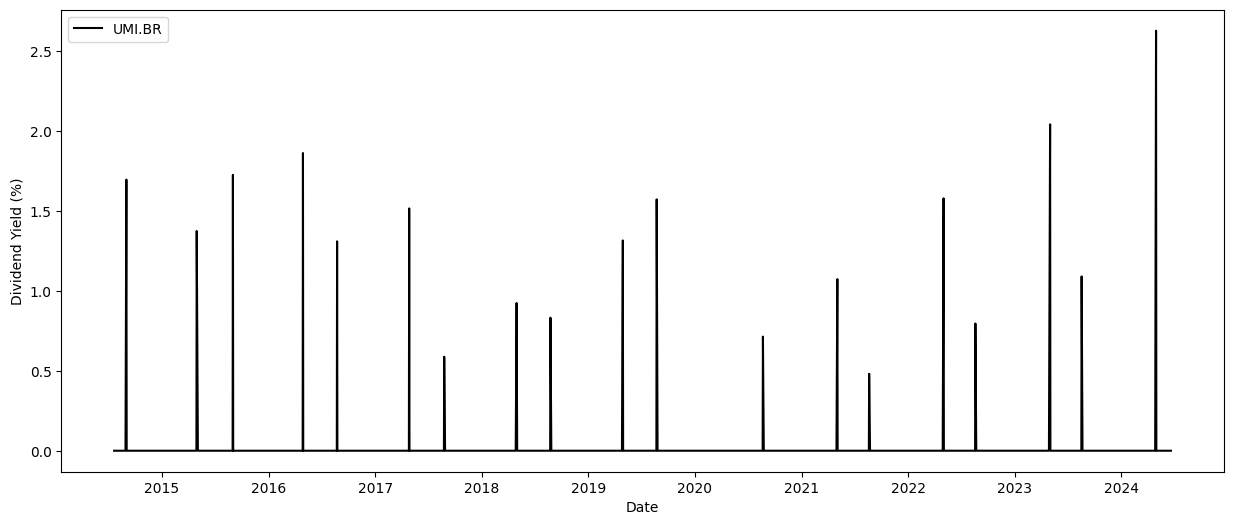

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.203112
share_price      1.000000
Name: share_price, dtype: float64


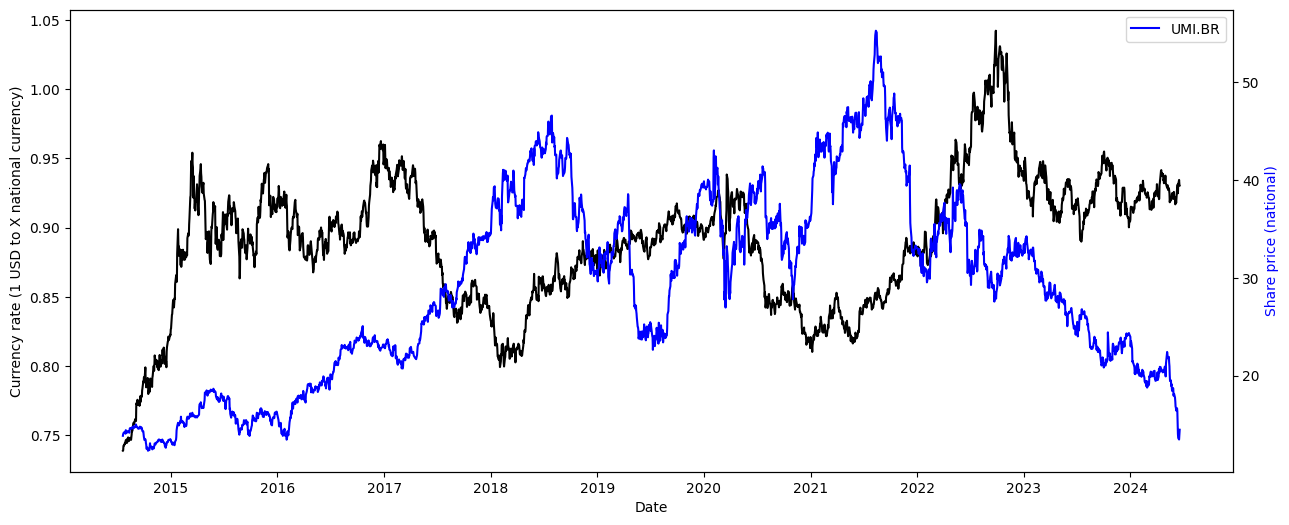

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

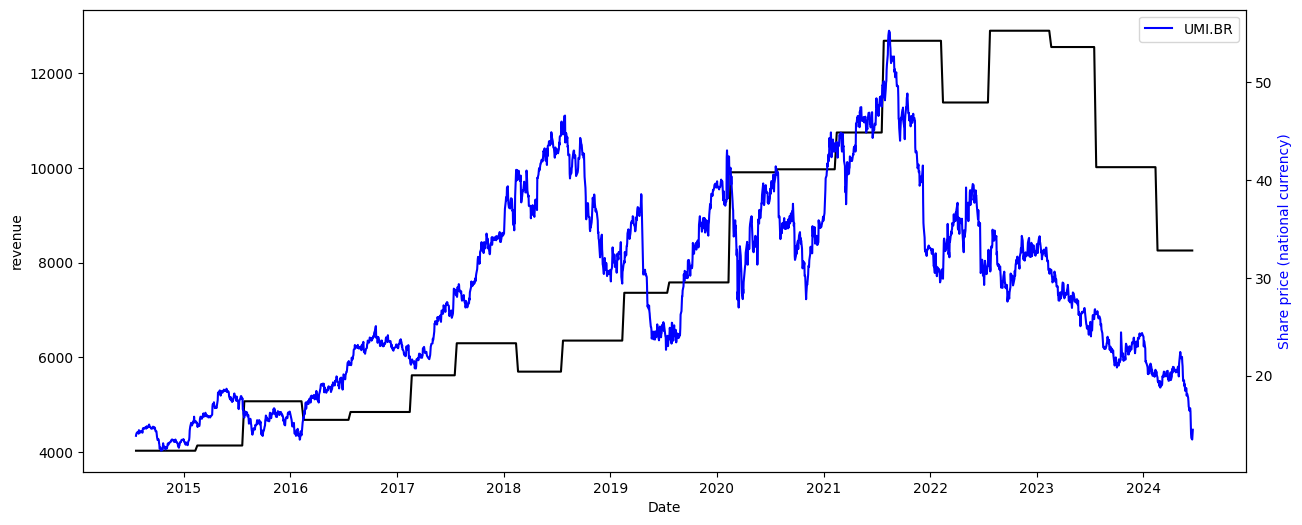

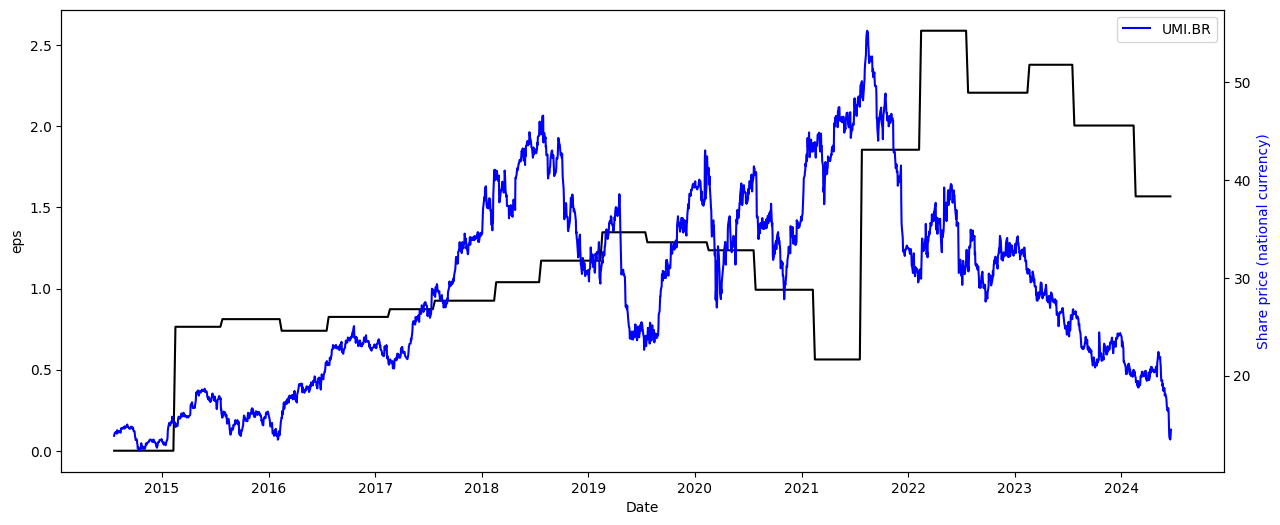

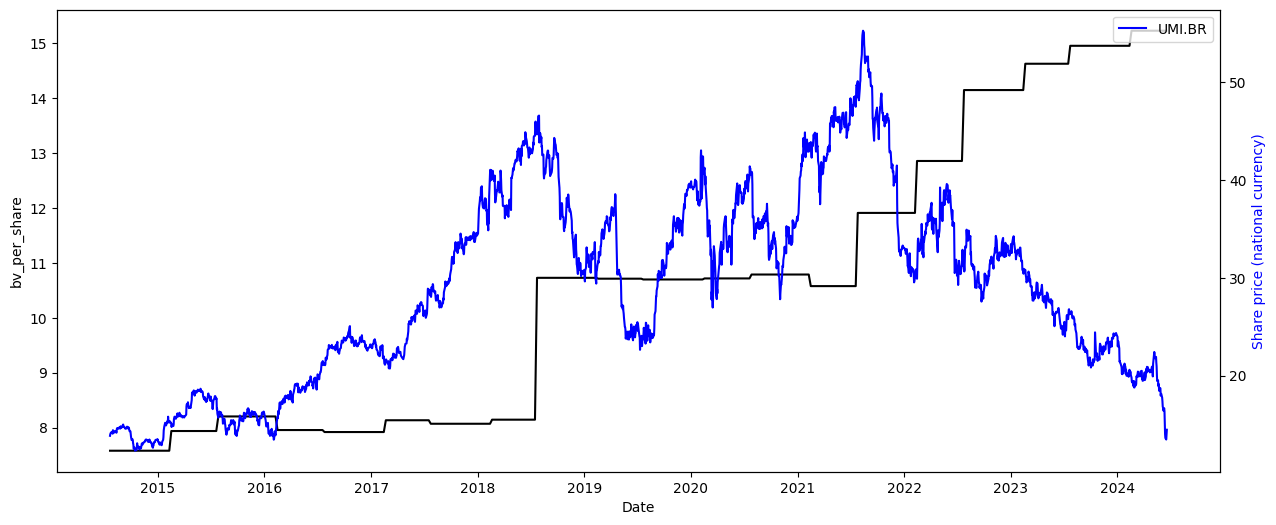

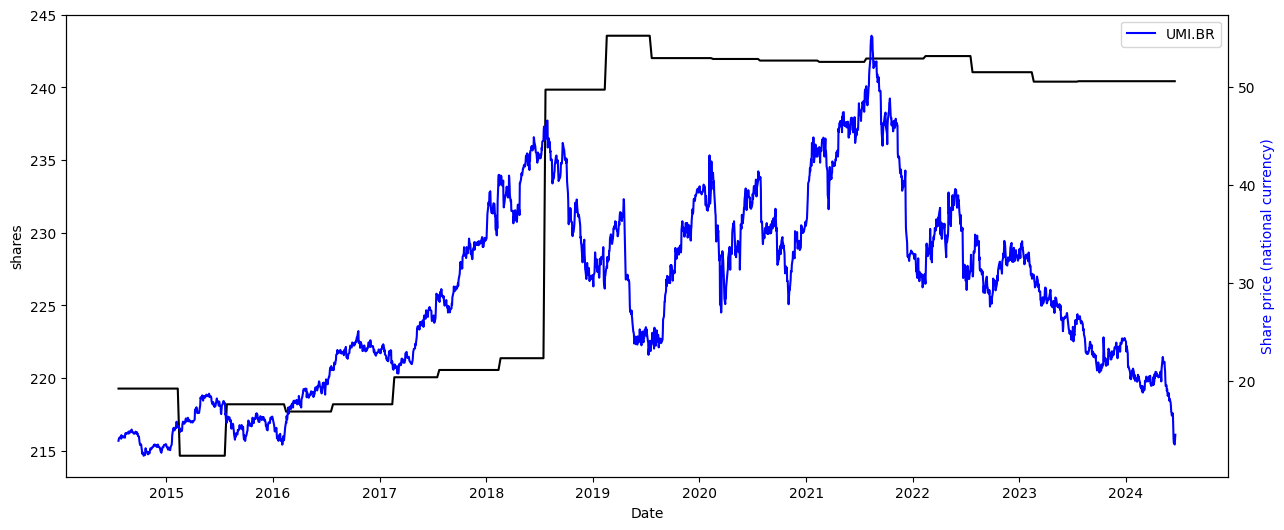

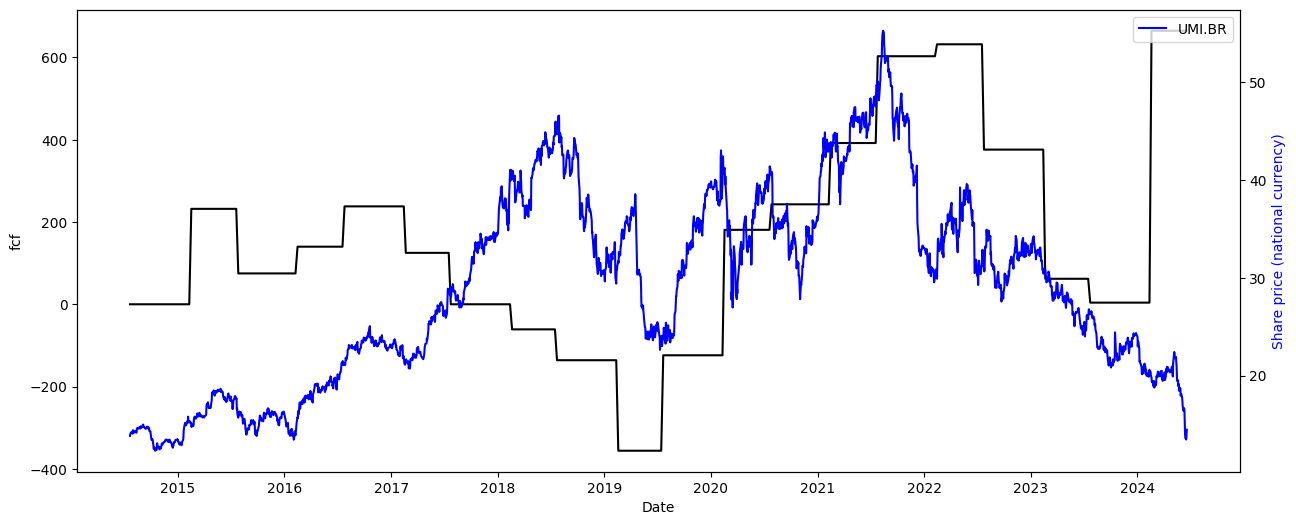

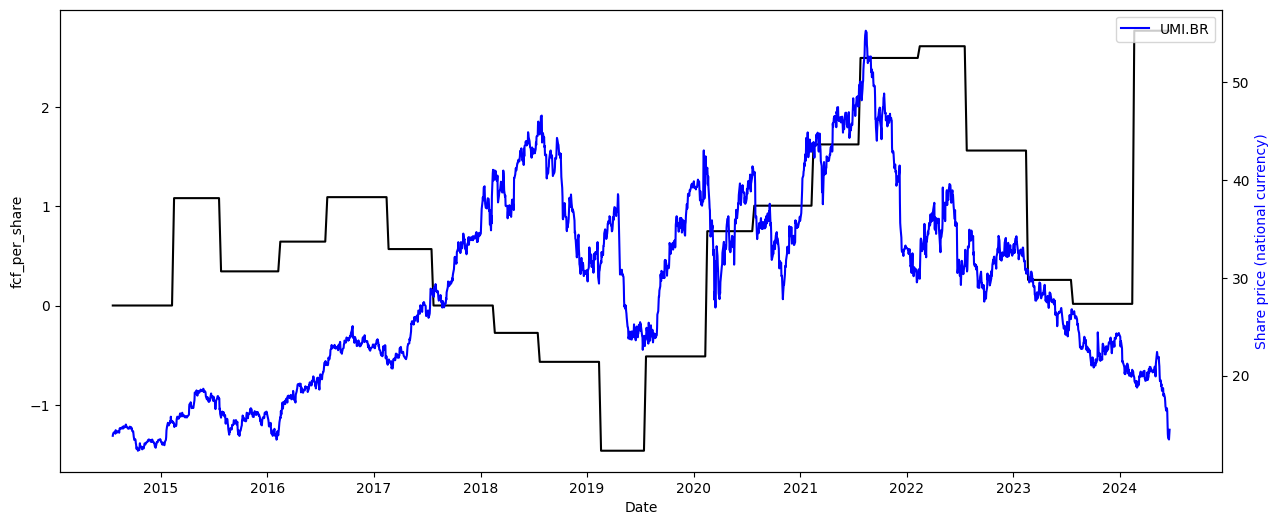

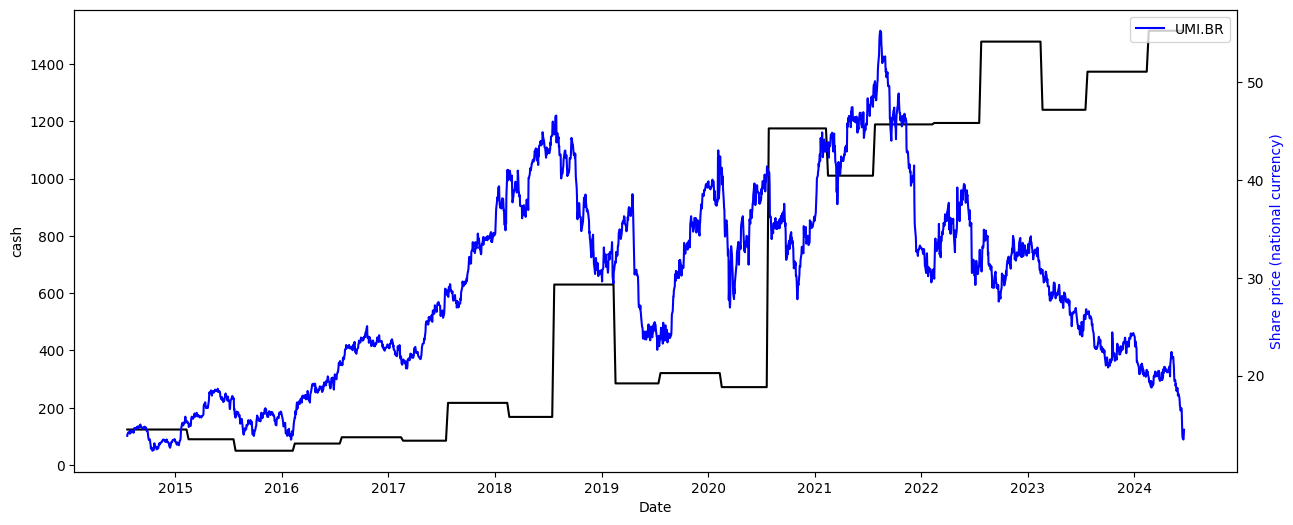

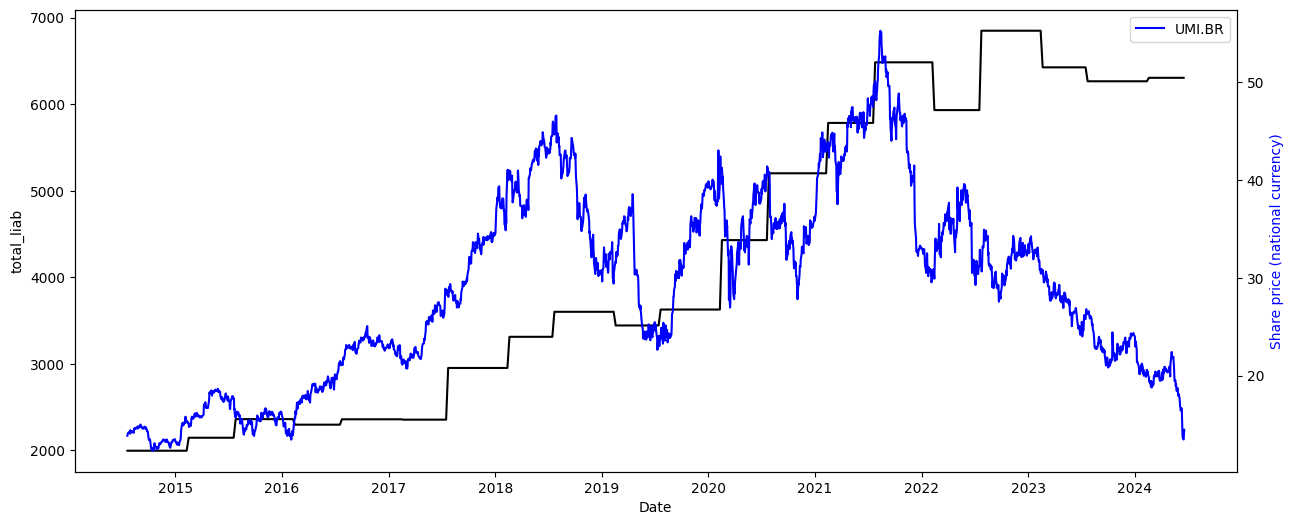

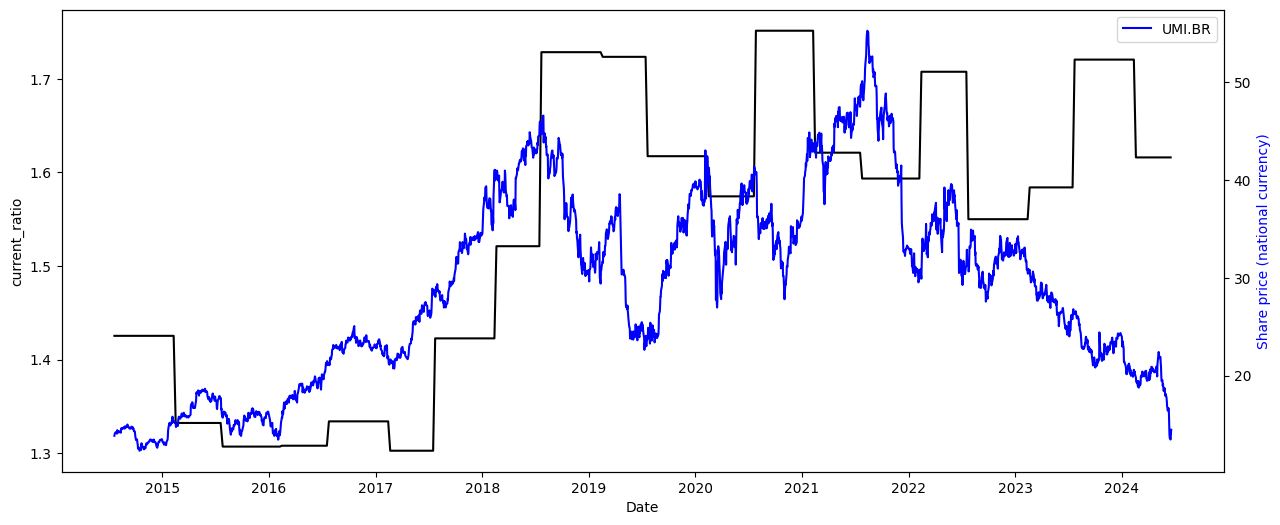

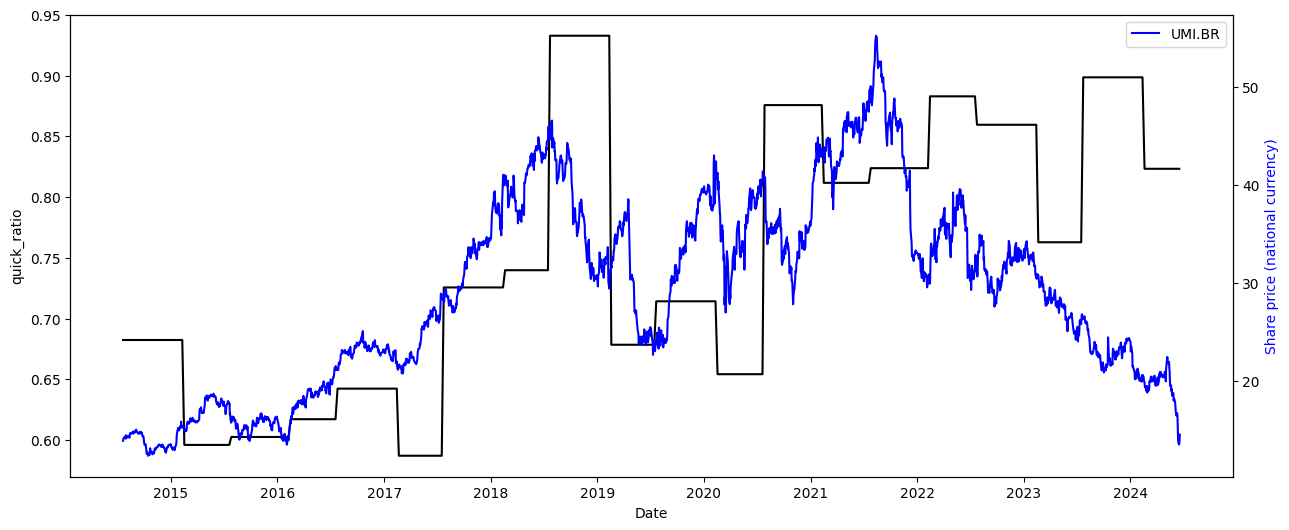

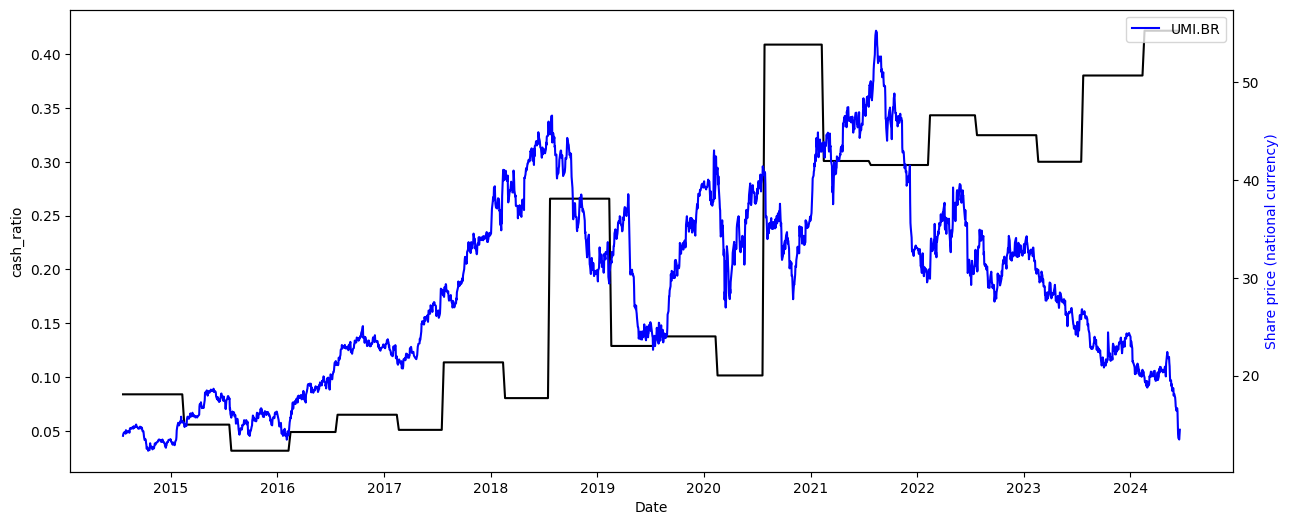

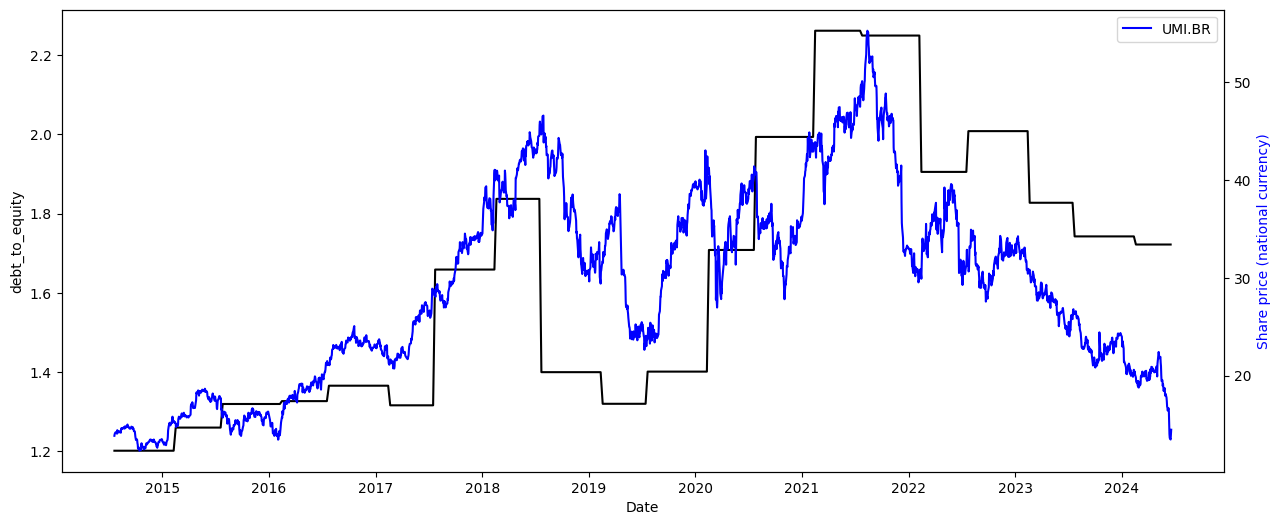

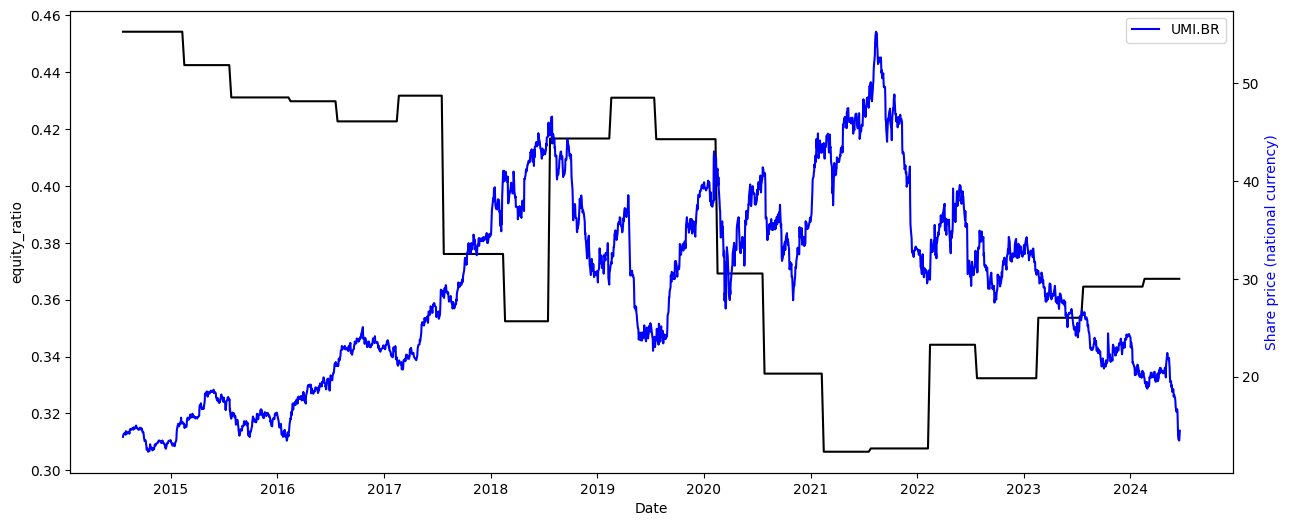

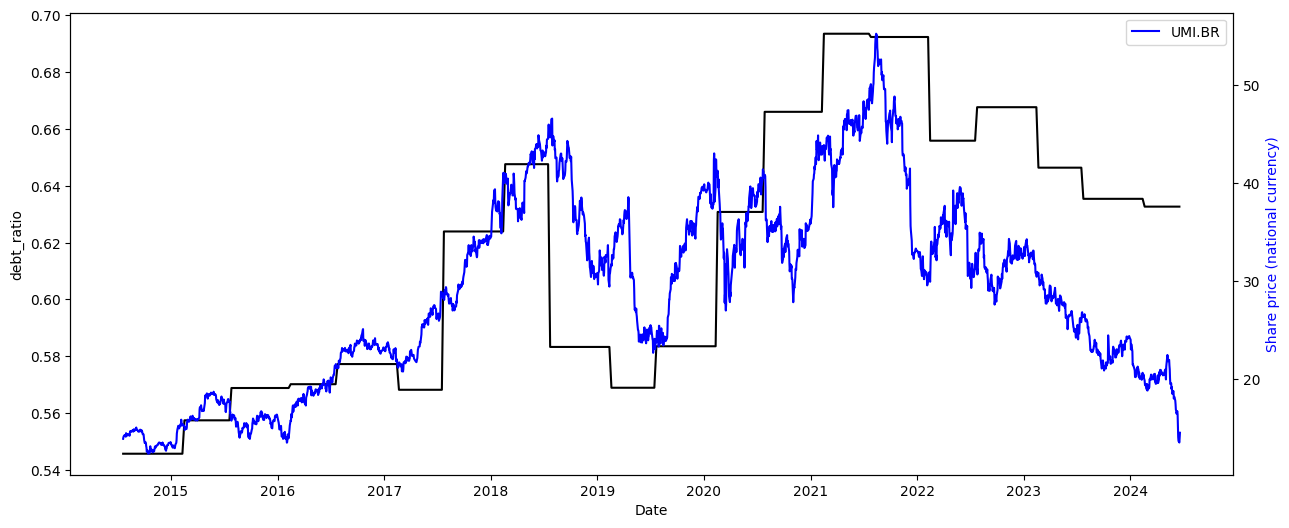

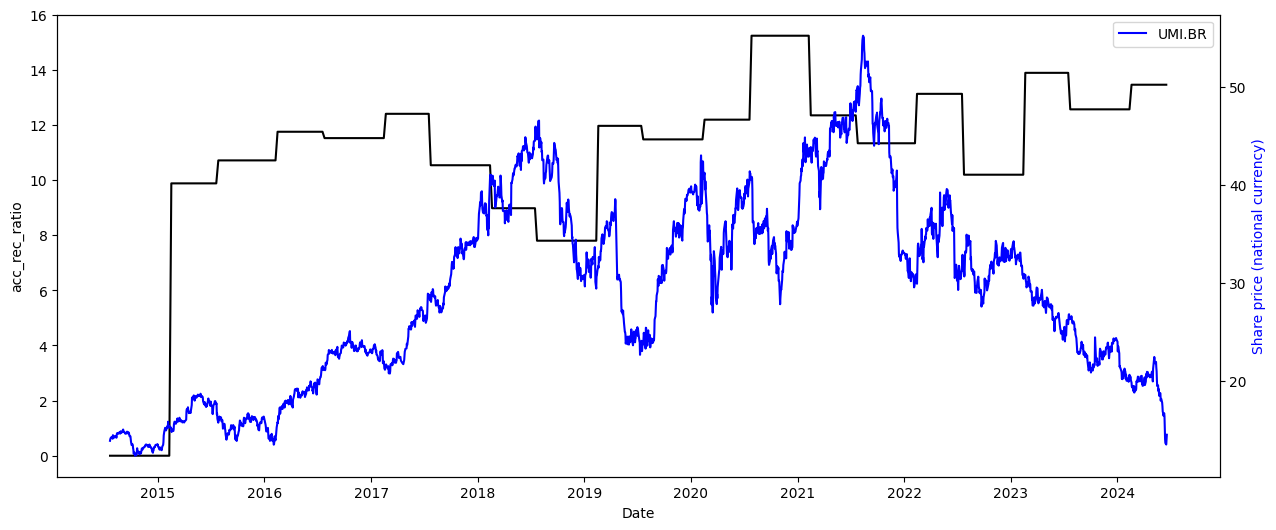

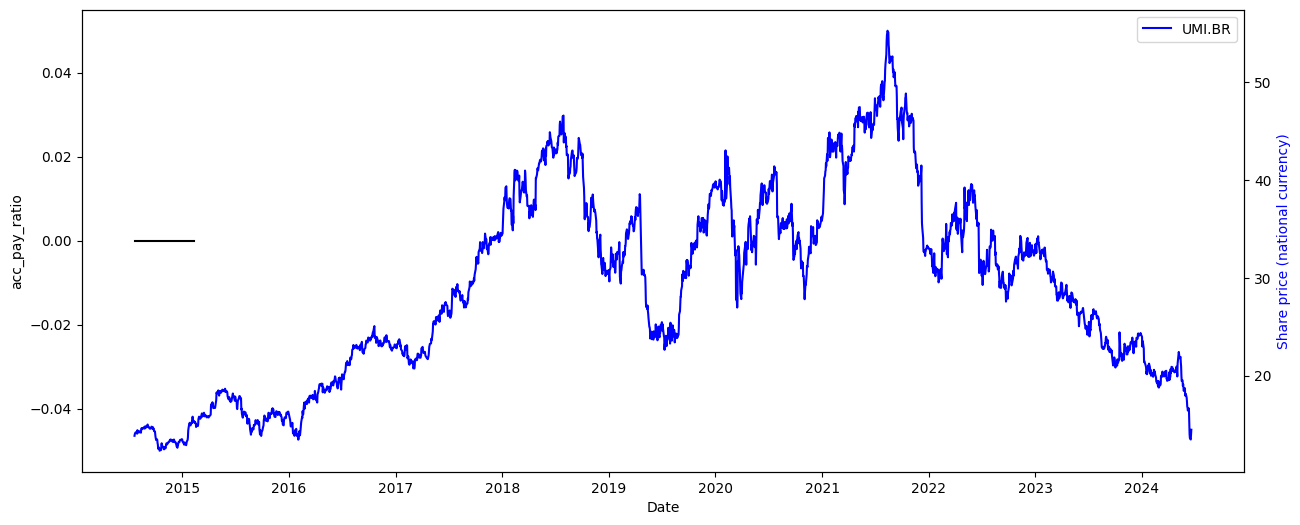

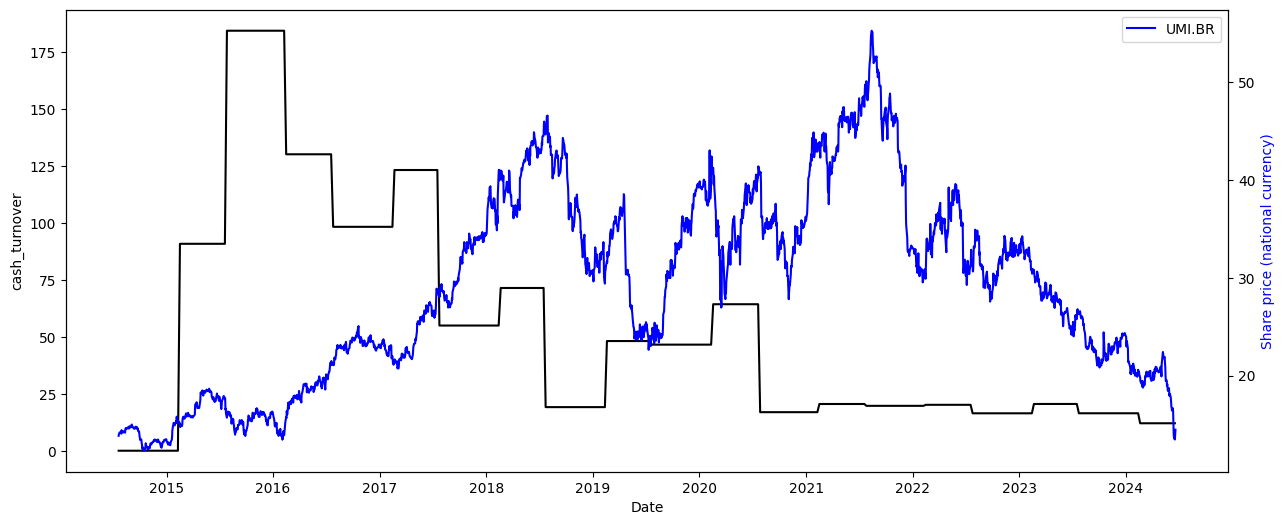

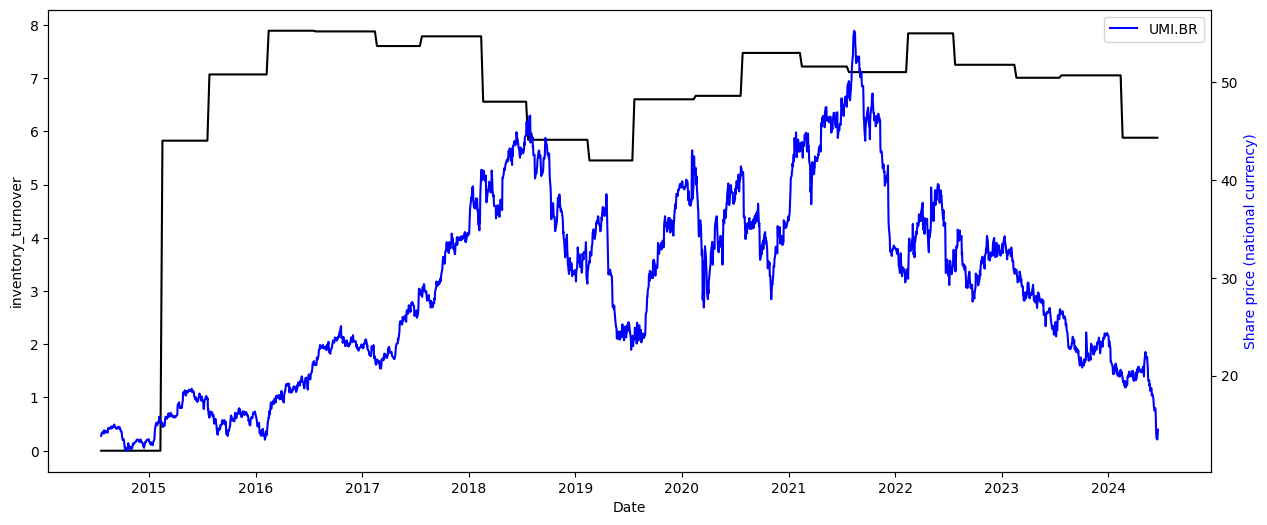

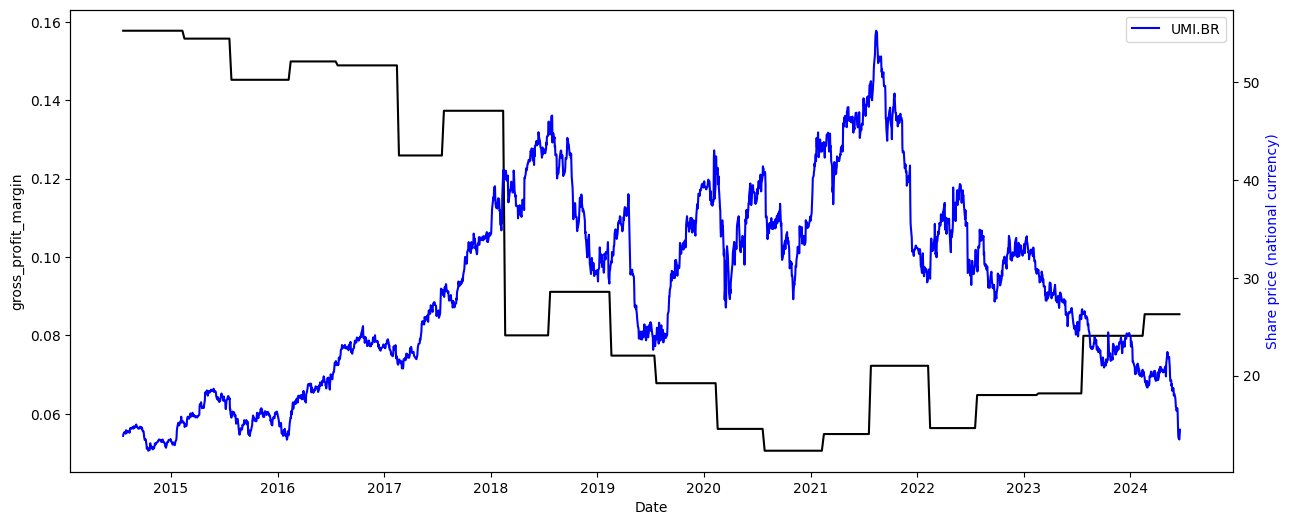

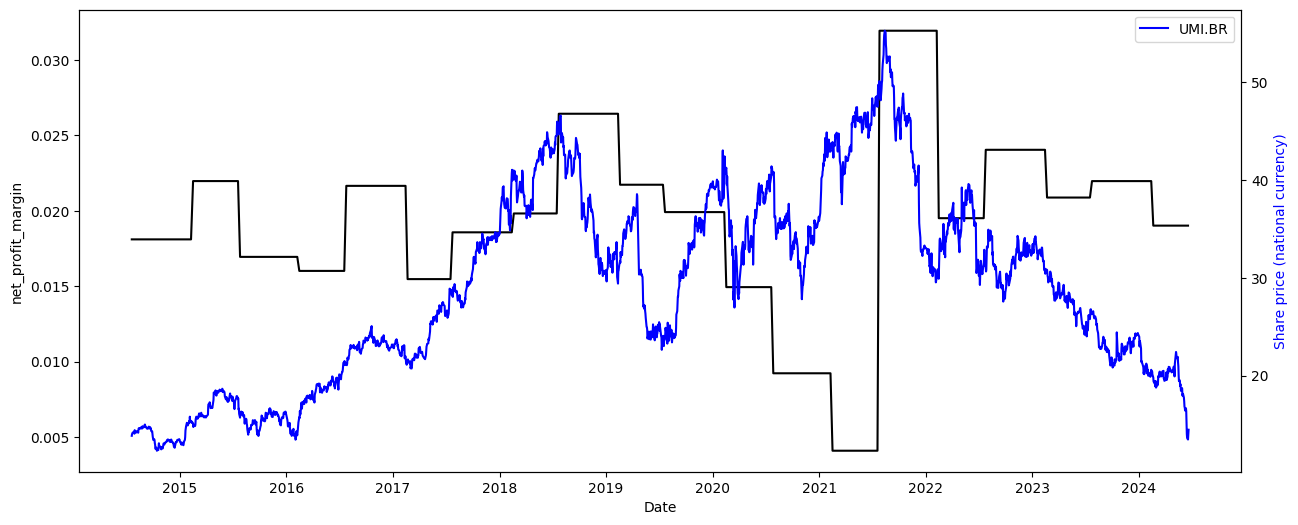

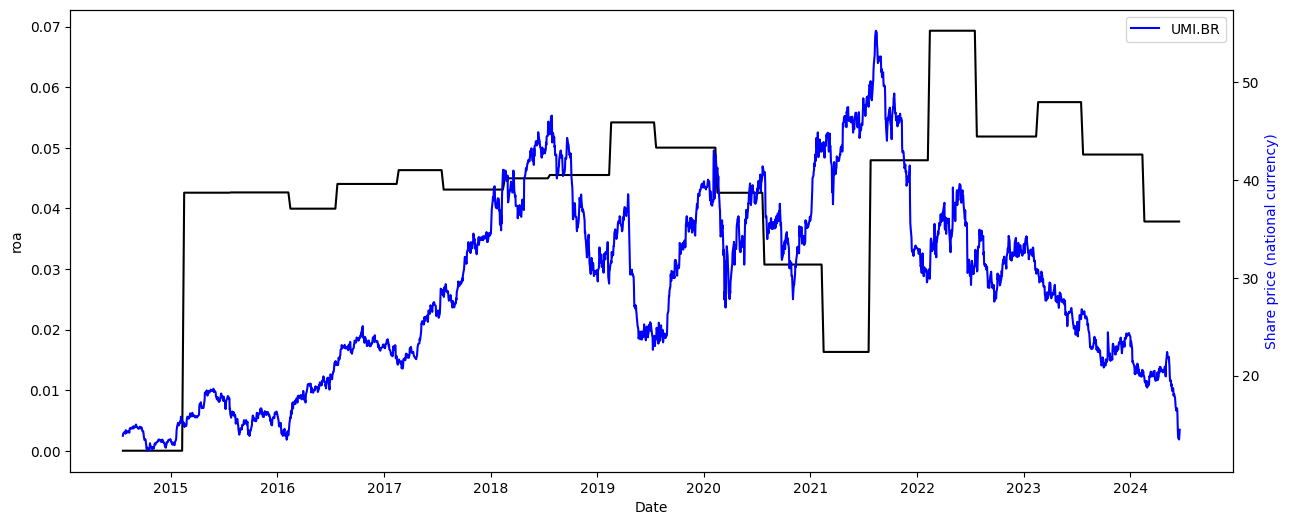

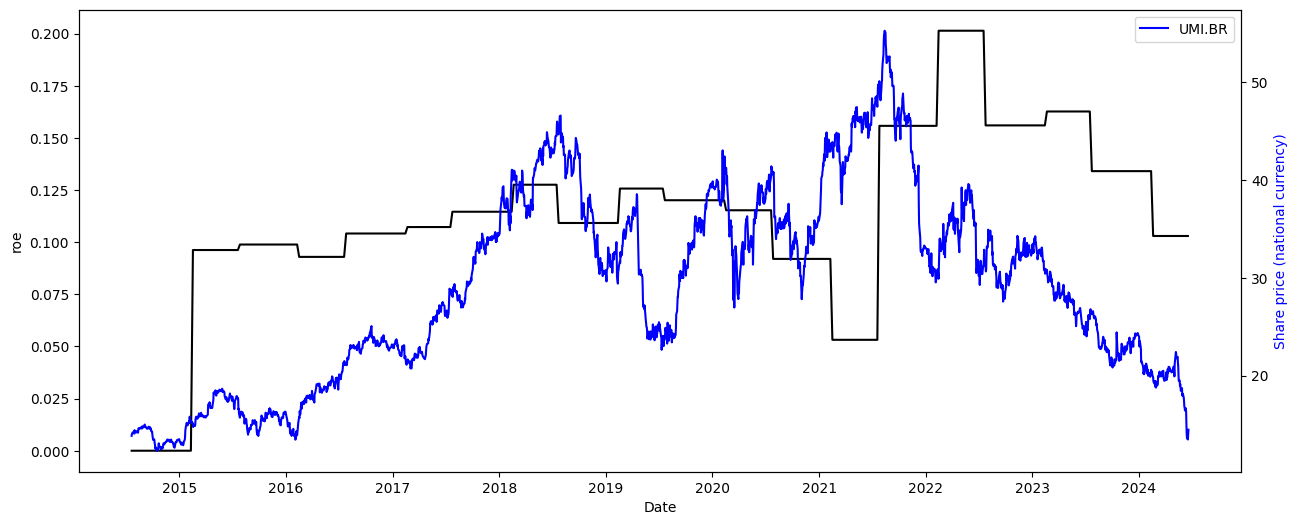

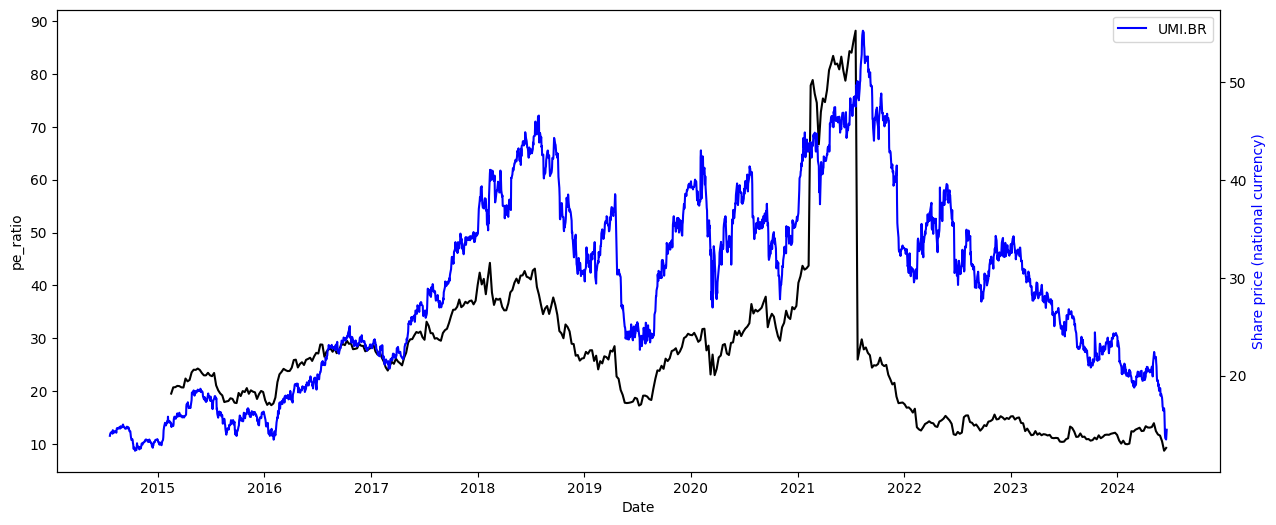

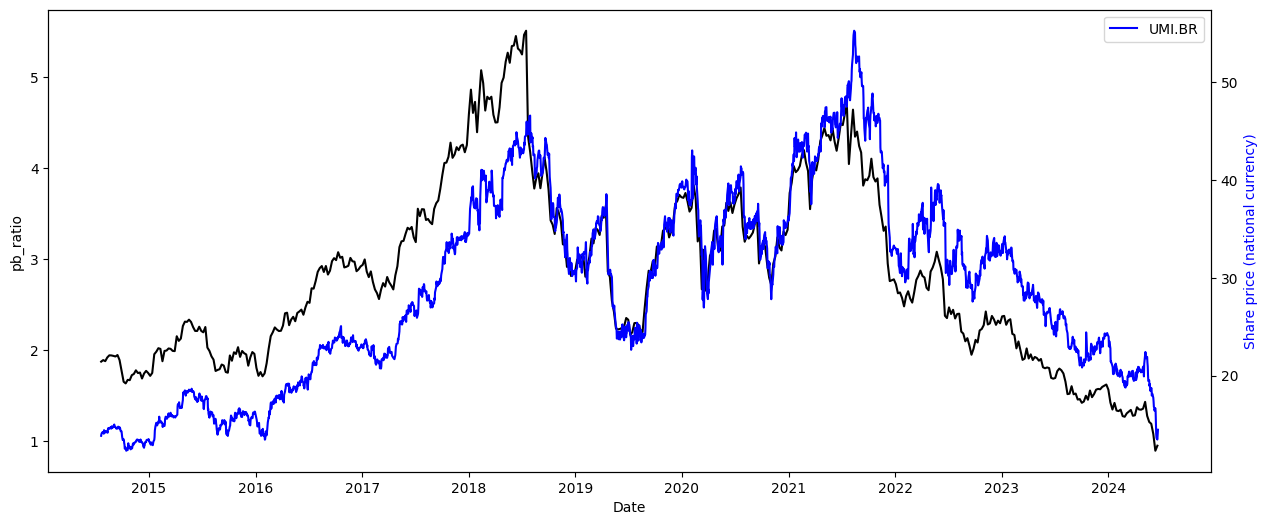

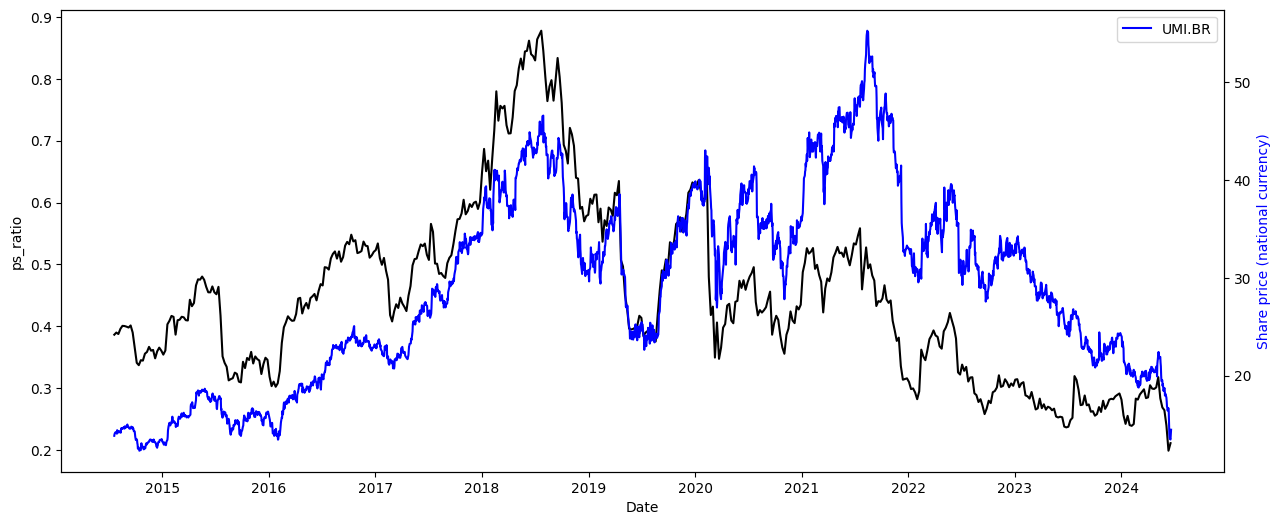

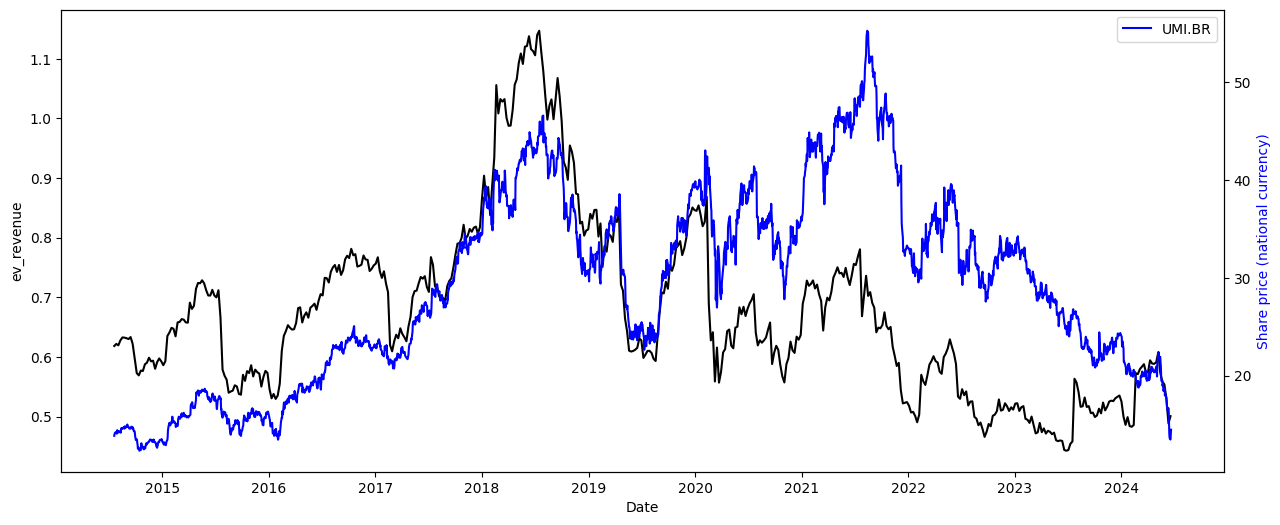

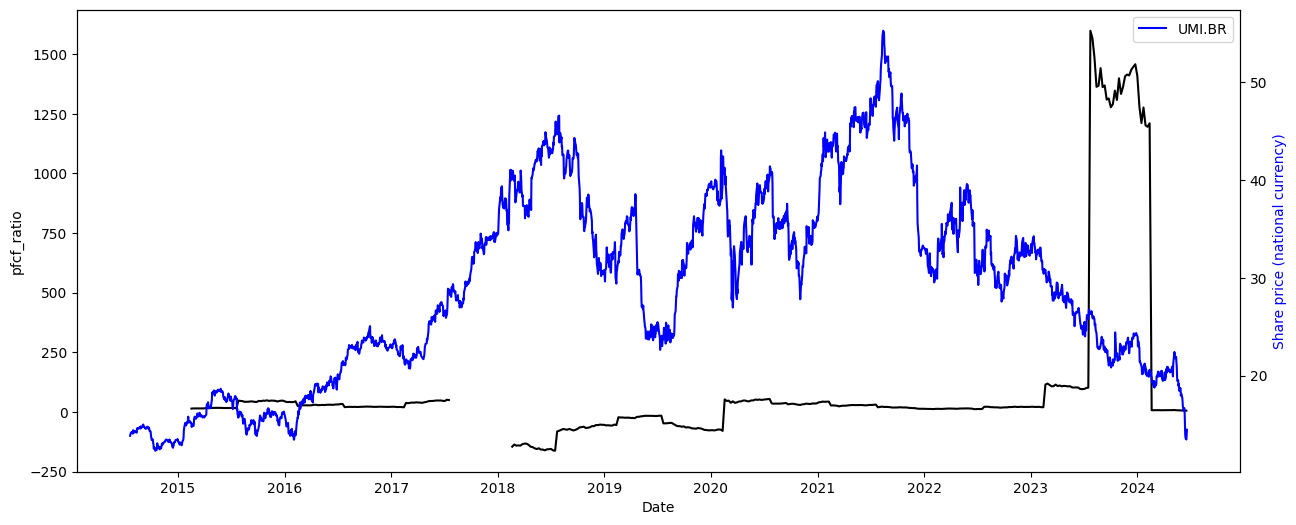

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

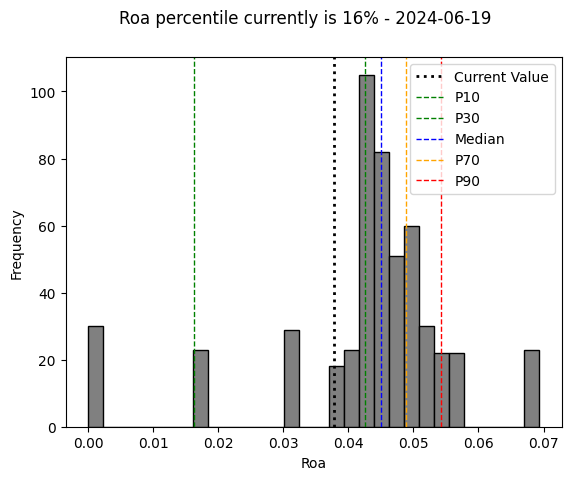

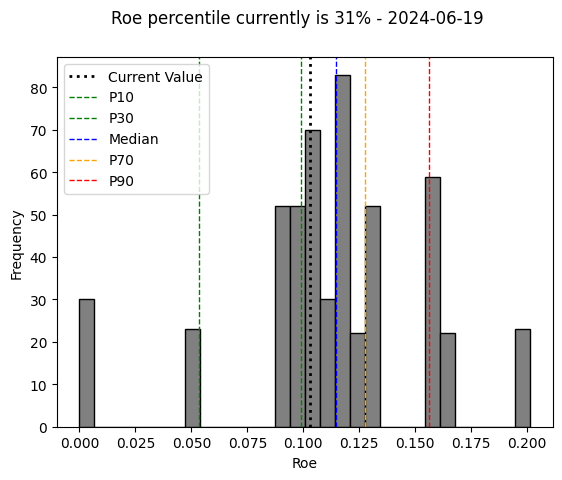

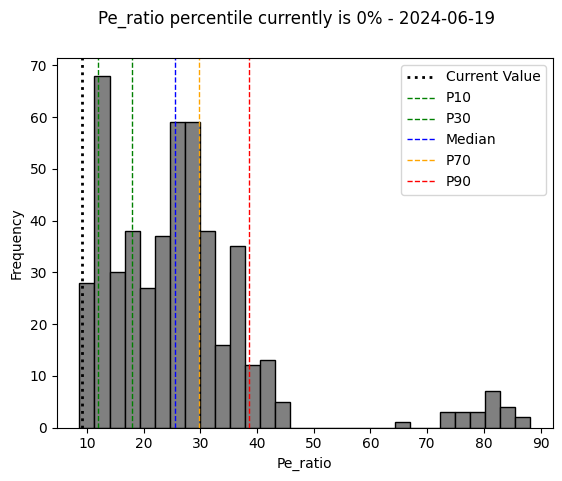

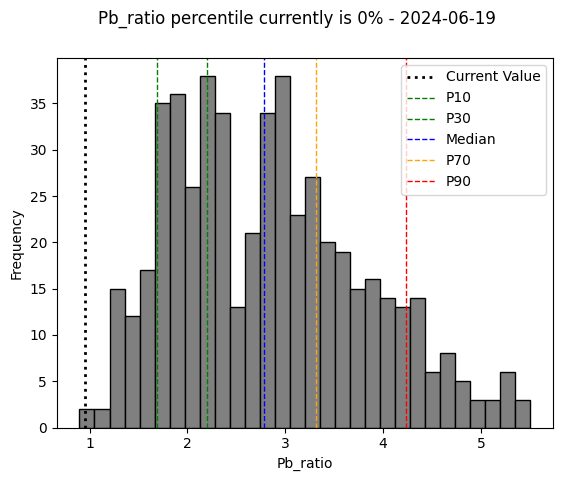

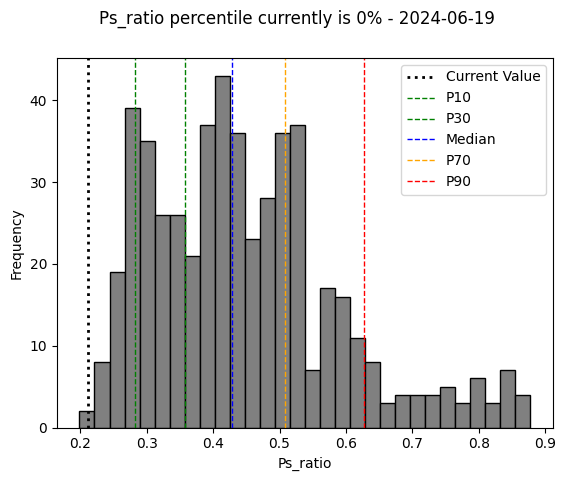

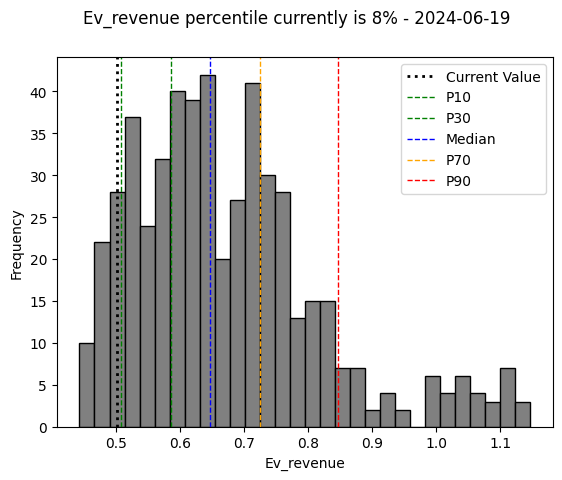

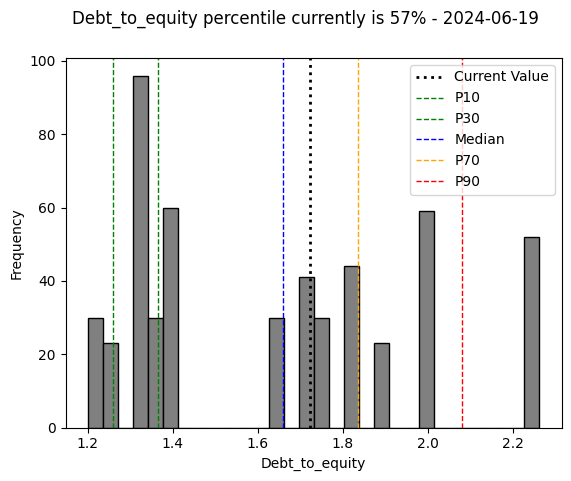

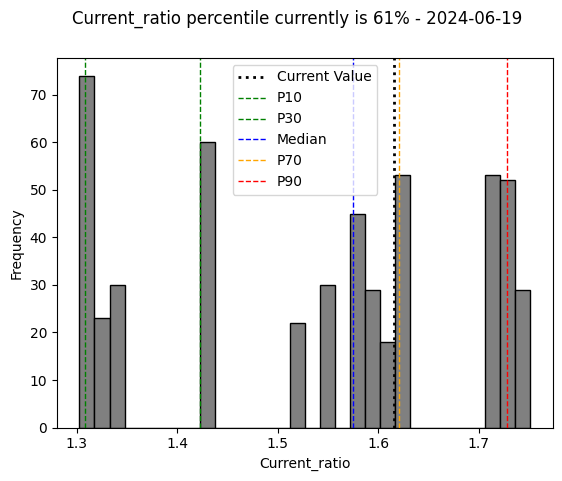

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.945124,-0.750351,-0.001181,-0.034271,-0.058897,0.136240,0.212135
roe,0.945124,1.000000,-0.640952,0.050052,-0.121634,-0.151627,0.420767,0.340185
pe_ratio,-0.750351,-0.640952,1.000000,0.742024,0.574303,0.547049,0.262409,0.012070
pb_ratio,-0.001181,0.050052,0.742024,1.000000,0.836175,0.787671,0.327492,0.114075
ps_ratio,-0.034271,-0.121634,0.574303,0.836175,1.000000,0.989866,-0.150142,-0.007241
ev_revenue,-0.058897,-0.151627,0.547049,0.787671,0.989866,1.000000,-0.178175,-0.026501
debt_to_equity,0.136240,0.420767,0.262409,0.327492,-0.150142,-0.178175,1.000000,0.512630
current_ratio,0.212135,0.340185,0.012070,0.114075,-0.007241,-0.026501,0.512630,1.000000


18 timestemos have been found!


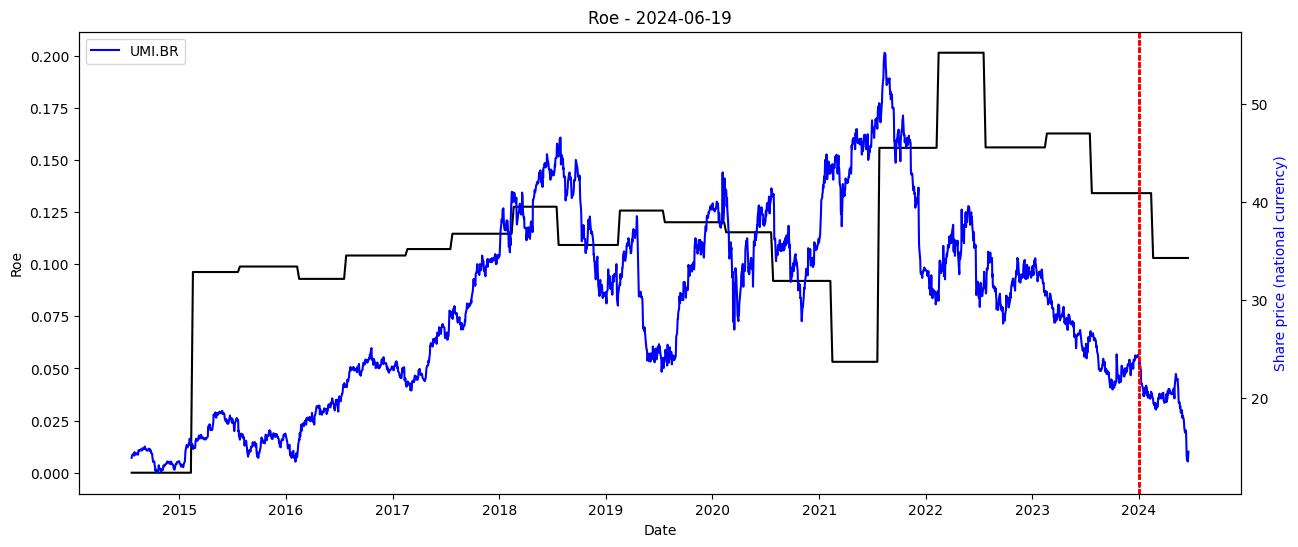

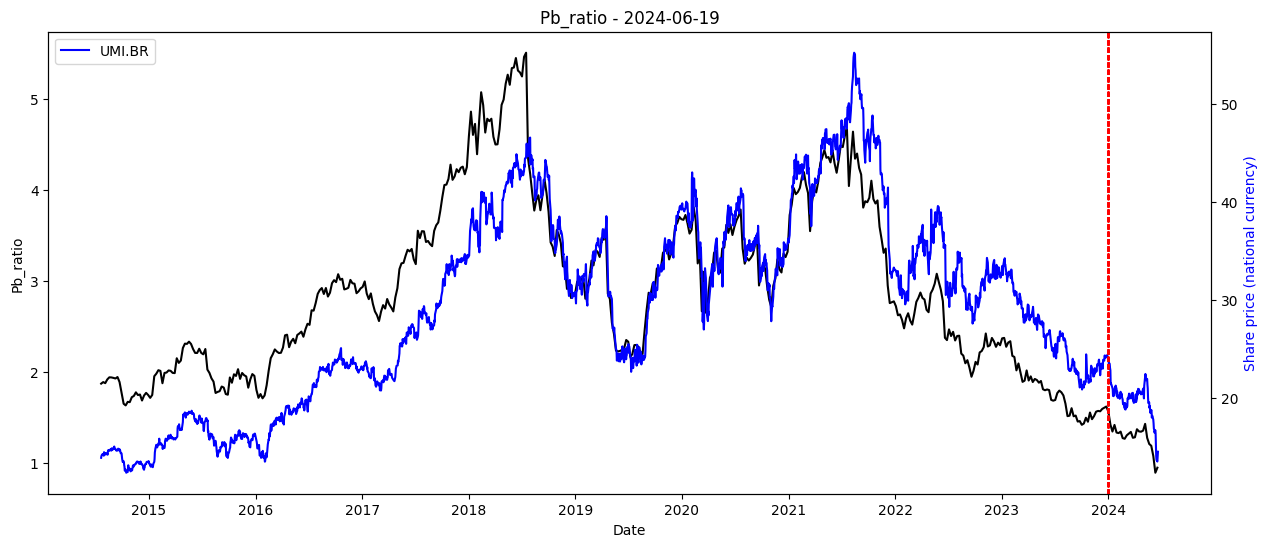

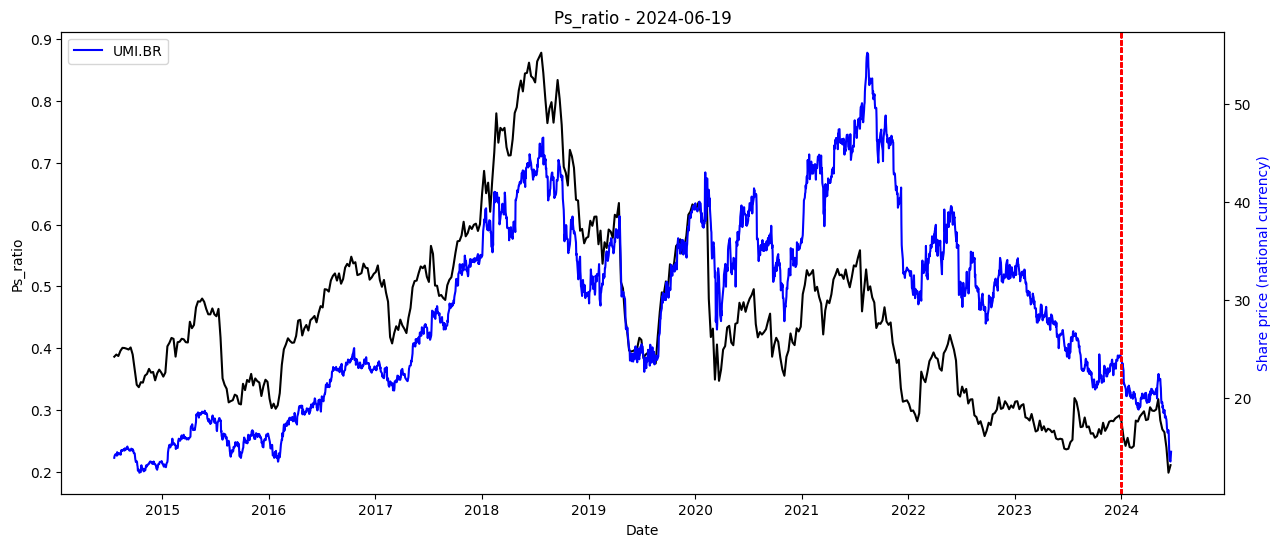

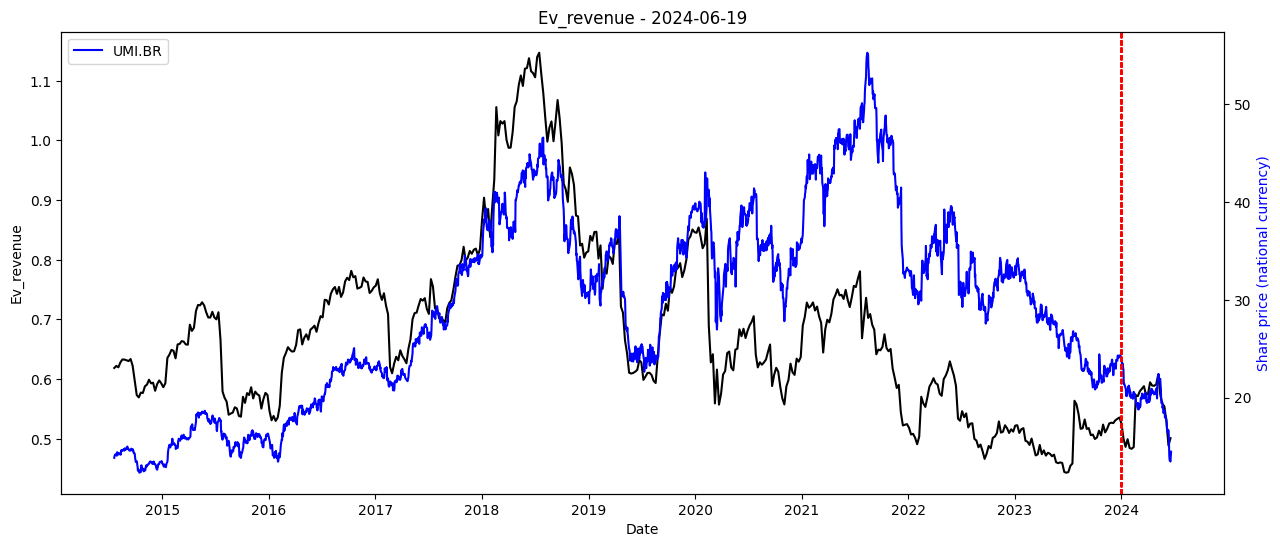

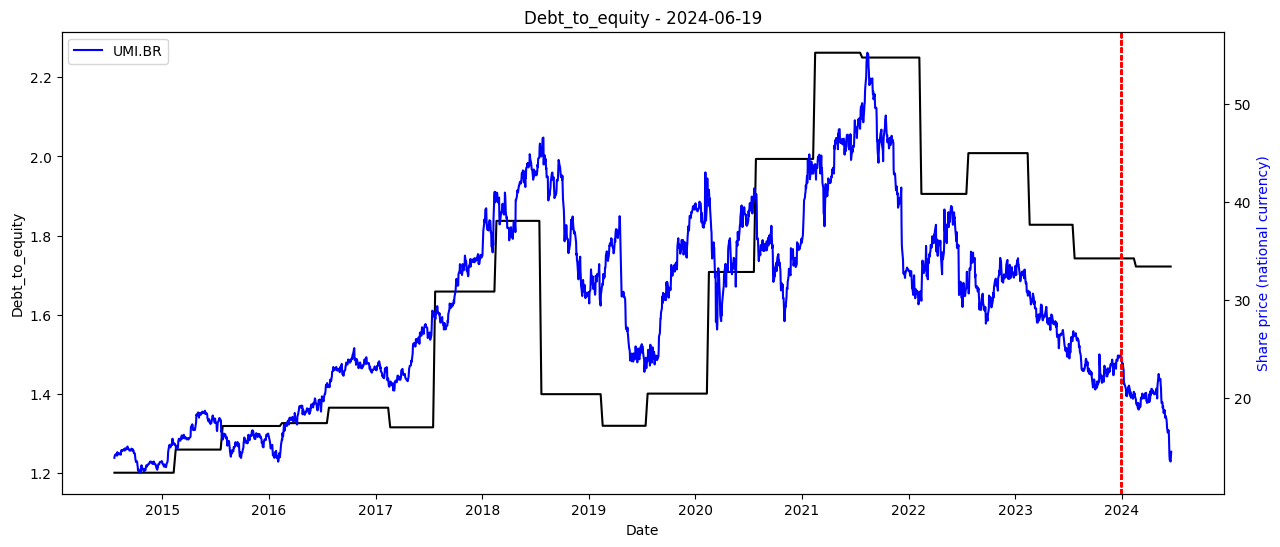

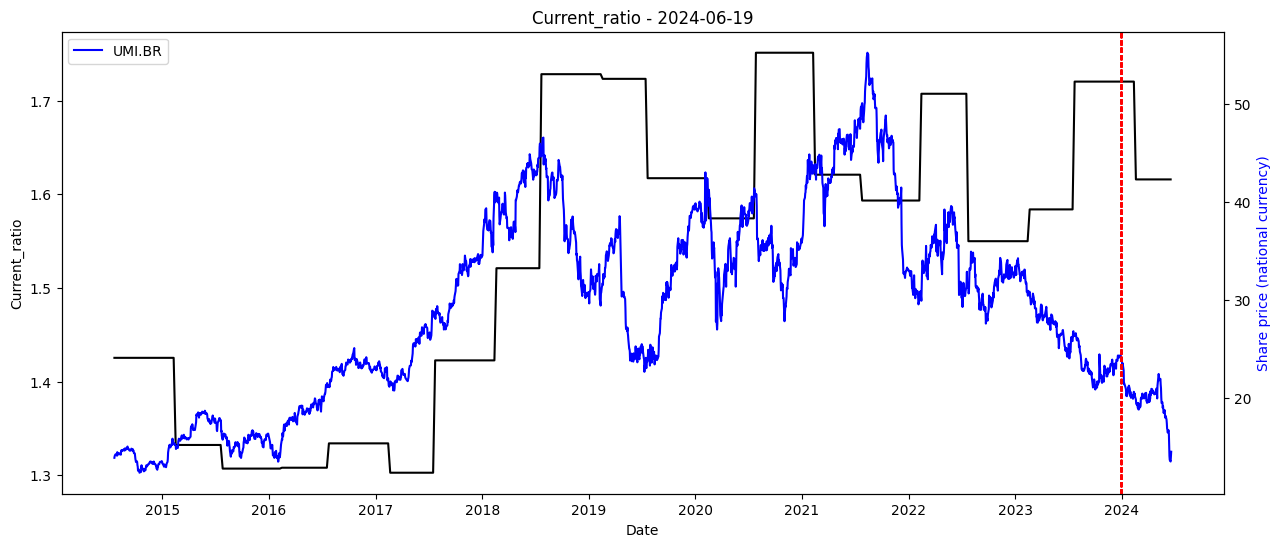

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )